In [3]:
import numpy as np
import plotly.graph_objects as go
!pip install numpy_financial
import numpy_financial as npf
!pip install pandas openpyxl
from scipy.optimize import fsolve

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

file_path = "/content/drive/My Drive/Selected_bonds.xlsx"

df = pd.read_excel(file_path, engine="openpyxl", usecols=None)  # Ensures all columns are read
df = df.iloc[:, 1:]
last_column = [98.81, 98.6, 98.53, 98.54, 97.96, 97.61, 97.38, 97.76, 98.4, 98.47, 98.69]
df['0.0275,CA135087S471,10/3/2024,3/1/2030'] = last_column


coupon_rates = [1.25, 0.5, 0.25, 1.0, 1.25, 2.75, 3.5, 3.25, 4.0, 3.5, 2.75]
maturities = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]

bond_array = [
    [(price, coupon_rates[i], maturities[i]) for price in df.iloc[:, i]]
    for i in range(len(df.columns))
]

# Output
print(bond_array)
print(len(bond_array))
print(len(bond_array[0]))

bond_array2 = list(map(list, zip(*bond_array)))
print(bond_array2)
print(len(bond_array2))
print(len(bond_array2[0]))



"""
bond_array = [
    [(col[i], coupon_rates[i], maturities[i]) for i in range(len(coupon_rates))]
    for col in df.to_numpy()
]

# Print the result
print(bond_array)
print(len(bond_array))
print(len(bond_array[0]))
"""



[[(99.73, 1.25, 0.25), (99.73, 1.25, 0.25), (99.74, 1.25, 0.25), (99.73, 1.25, 0.25), (99.74, 1.25, 0.25), (99.73, 1.25, 0.25), (99.73, 1.25, 0.25), (99.77, 1.25, 0.25), (99.78, 1.25, 0.25), (99.8, 1.25, 0.25), (99.8, 1.25, 0.25)], [(98.4, 0.5, 0.75), (98.41, 0.5, 0.75), (98.4, 0.5, 0.75), (98.42, 0.5, 0.75), (98.37, 0.5, 0.75), (98.36, 0.5, 0.75), (98.36, 0.5, 0.75), (98.4, 0.5, 0.75), (98.47, 0.5, 0.75), (98.5, 0.5, 0.75), (98.53, 0.5, 0.75)], [(96.99, 0.25, 1.25), (96.98, 0.25, 1.25), (96.97, 0.25, 1.25), (97.0, 0.25, 1.25), (96.9, 0.25, 1.25), (96.91, 0.25, 1.25), (96.8, 0.25, 1.25), (96.9, 0.25, 1.25), (97.01, 0.25, 1.25), (97.06, 0.25, 1.25), (97.1, 0.25, 1.25)], [(97.01, 1.0, 1.75), (96.99, 1.0, 1.75), (97.0, 1.0, 1.75), (97.03, 1.0, 1.75), (96.86, 1.0, 1.75), (96.77, 1.0, 1.75), (96.71, 1.0, 1.75), (96.85, 1.0, 1.75), (97.03, 1.0, 1.75), (97.07, 1.0, 1.75), (97.11, 1.0, 1.75)], [(96.62, 1.25, 2.25), (96.59, 1.25, 2.25), (96.58, 1.25, 2.25), (96.63, 1.25, 2.25), (96.39, 1.25, 2.

'\nbond_array = [\n    [(col[i], coupon_rates[i], maturities[i]) for i in range(len(coupon_rates))]\n    for col in df.to_numpy()\n]\n\n# Print the result\nprint(bond_array)\nprint(len(bond_array))\nprint(len(bond_array[0]))\n'

## Calculating dirty prices

Note that since the bonds mature in 6 month intervals, the last coupon payment date of all the bonds before the settlement date are the same. For example, the last coupon payment date of the bond that matures on March 1 2025 relative to the settlement date of Jan 6 2025 was on Sep 1 2024 which is the same for all the bonds in our dataset since they have semiannual coupon payments. So the value of n in the accrued interest formula will be n = (settlement_date - Sep 1 2024)


In [94]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def calculate_dirty_price(clean_price, maturity_date, settlement_date, coupon_rate, face_value=100):
    """
    Calculate the dirty price of a bond.

    Parameters:
        clean_price (float): The clean price of the bond (excluding accrued interest).
        maturity_date (str): The bond's maturity date in 'YYYY-MM-DD' format.
        settlement_date (str): The bond's settlement date in 'YYYY-MM-DD' format.
        coupon_rate (float): The annual coupon rate as a decimal (e.g., 0.05 for 5%).
        face_value (float): The face value of the bond (default is 100).

    Returns:
        float: The dirty price of the bond.
    """
    # Convert dates to datetime objects
    maturity_date = datetime.strptime(maturity_date, "%Y-%m-%d")
    settlement_date = datetime.strptime(settlement_date, "%Y-%m-%d")

    # Step 1: Find the last coupon payment date
    last_cpn_payment_date = maturity_date
    while last_cpn_payment_date > settlement_date:
        last_cpn_payment_date -= relativedelta(months=6)

    # Step 2: Calculate the number of days between today (settlement_date) and last_cpn_payment_date
    n = (settlement_date - last_cpn_payment_date).days

    # Step 3: Calculate accrued interest
    annual_coupon_payment = face_value * coupon_rate
    accrued_interest = (n / 365) * annual_coupon_payment

    # Step 4: Calculate dirty price
    dirty_price = clean_price + accrued_interest

    return dirty_price

# Example usage
clean_price = 98.50
maturity_date = "2030-12-31"
settlement_date = "2025-01-27"
coupon_rate = 0.05  # 5%

dirty_price = calculate_dirty_price(clean_price, maturity_date, settlement_date, coupon_rate)
print(f"Dirty Price: {dirty_price:.2f}")


Dirty Price: 98.88


##Python function to calculate the YTMs


In [43]:
def bond_ytm(price, annual_coupon, F, maturity):
    """
    Solves for yield to maturity (YTM) given bond parameters.

    price: Present Value of the bond (Price)
    coupon_rate: Annual coupon rate (as percentage)
    F: Face value of the bond (default 100)
    maturity: Time to maturity in years
    """


    semiannual_coupon = annual_coupon / 2

    periods = int(maturity * 2)+1 # Total number of times coupon payments are made

    cash_flows = np.array([-price] + [semiannual_coupon] * (periods - 1) + [semiannual_coupon + 100])

    annual_ytm = npf.irr(cash_flows)





    return annual_ytm

In [44]:
ytm_array = []

for i in range(len(bond_array)):
  ytm_subarray = []
  for j, (PV, coupon_rate, maturity) in enumerate(bond_array[i]):
    ytm = bond_ytm(PV, coupon_rate, 100, maturity)
    ytm_subarray.append(ytm)

  ytm_array.append(ytm_subarray)

print(ytm_array)
print(len(ytm_array))
print(len(ytm_array[0]))

ytm_array2 = list(map(list, zip(*ytm_array)))
print(ytm_array2)
print(len(ytm_array))
print(len(ytm_array[0]))

[[0.008974230422139629, 0.008974230422139629, 0.00887306998195303, 0.008974230422139629, 0.00887306998195303, 0.008974230422139629, 0.008974230422139629, 0.008569710333767633, 0.008468630988174075, 0.008266533066132231, 0.008266533066132231], [0.010627757797995407, 0.010576344053222275, 0.010627757797995407, 0.010524938151086127, 0.01078204610808231, 0.010833491243351867, 0.010833491243351867, 0.010627757797995407, 0.010268026210223491, 0.010113973029889367, 0.009959990272065289], [0.01151528866453555, 0.011550098799686381, 0.011584913725108725, 0.01148048331850271, 0.011828752427601064, 0.011793903937959538, 0.012177501488081166, 0.011828752427601064, 0.011445682760434783, 0.01127175174925732, 0.01113269300625519], [0.012714095470754527, 0.012766696821647328, 0.012740394442965597, 0.012661507742568023, 0.013108938094746225, 0.013346212598710716, 0.013504549681041977, 0.013135288247461352, 0.012661507742568023, 0.012556373128945975, 0.012451292930081959], [0.013281722436933485, 0.01334

## Template Bootstrap Function

In [70]:
import numpy as np

def spot_rate_curve(day_bonds):
    """
    Bootstraps the spot rate curve for bonds with fractional maturities (e.g., 1/4, 3/4 years)
    and semiannual coupon payments.

    Parameters:
        day_bonds (list of tuples): Each tuple contains (price, annual_coupon_rate, maturity_years).
                                - price: bond price
                                - annual_coupon_rate: annual coupon payment rate
                                - maturity_years: bond maturity in years (e.g., 1/4, 3/4, etc.)

    Returns:
        The spot_rate_curve function should return a list of spot rates of all the bonds
        for a particular day

    """

    spot_rates = []

    for i, (PV, coupon_rate, maturity) in enumerate(sorted(day_bonds, key=lambda x: x[2])):

      C = (coupon_rate / 2)   # Coupon payment

      # Generate time factors for discounting (semiannual payments)
      num_periods = int(maturity * 2) +1  # This is the number of  payments left for this bond and also becomes the exponent
      cash_flows = np.array([C]* (num_periods - 1) + [100+C])

      if num_periods == 1:
            # For the first bond, spot rate is derived directly
            spot_rate = ((cash_flows[-1] / PV) ** (1 / num_periods)) - 1


      else: #Say num_periods = 3
            # Discount earlier cash flows using known spot rates
            dcf = 0
            for i in range(num_periods - 1): # 0,1
              dcf = dcf + (C / ((1 + spot_rates[i]) ** (i+1)))

            spot_rate = ((cash_flows[-1] / (PV - dcf)) ** (1 / num_periods)) - 1


            # Solve for the spot rate for the final cash flow


      spot_rates.append(spot_rate)

    return spot_rates





## Example Bond: Represents bond prices on any one given day

In [71]:
spot_rates_all = []

for i in range(len(bond_array2)): # So here i represents the day
    spot_rate_day = spot_rate_curve(bond_array2[i])
    spot_rates_all.append(spot_rate_day)

    # Append the calculated spot rate to the correct sublist in spot_rates
    # Append to spot_rates[i], not spot_rates[i][j]
print(spot_rates_all)

[[0.008974230422139629, 0.01062984488587948, 0.011517119757153083, 0.01272881283851679, 0.013303833679525479, 0.014478210199651231, 0.014850385633072172, 0.01487017012332048, 0.015253864183104593, 0.01518671267998184, 0.014987467582766367], [0.008974230422139629, 0.010578366040562281, 0.011552017738765574, 0.012781818699578507, 0.013368126071049424, 0.014604291463060193, 0.014847123725689526, 0.01481134769913095, 0.015328038854869552, 0.015276877593449756, 0.01520981188913395], [0.00887306998195303, 0.010629972793428921, 0.011586876798397983, 0.012755180700130264, 0.013389651007401193, 0.01464043967330686, 0.015036009637366288, 0.01501878927188427, 0.01546022417177828, 0.01538504395382212, 0.015277897771300397], [0.008974230422139629, 0.010526895061037767, 0.01148235694244737, 0.012676216750306502, 0.013282986795726925, 0.014570626763009686, 0.01500871114083524, 0.015093115034042093, 0.015501422652315133, 0.015456652933386605, 0.015267576289267115], [0.00887306998195303, 0.010784456602

We now apply linear interpolation to get the spot rates for the yearly intervals


In [72]:

def interpolate_spot_rates(spot_rates, intervals):
    """
    Linearly interpolates spot rates to find the rates at integer maturities (1, 2, 3, ... years).

    Parameters:
        spot_rates (np.array): Array of spot rates for fractional maturities (e.g., 0.25, 0.75, ...).
        intervals (float): The interval between spot rates in the input array (e.g., 0.25 years).

    Returns:
        list: A list of interpolated spot rates at integer maturities.
    """
    interpolated_rates = []
    for year in range(1, 6):  # For r(1), r(2), ..., r(5)
        lower_idx = int((year - intervals)) #5-0.25 = 4.75
        upper_idx = int((year + intervals)) # 5+0.25 = 5.25

        # Ensure indices are within bounds
        if lower_idx < 0 or upper_idx >= len(spot_rates):
            raise IndexError("Interpolation indices are out of bounds. Check the intervals or spot rates array.")



        lower_rate = spot_rates[2*year-1]
        upper_rate = spot_rates[2*year]

        # Perform linear interpolation
        interpolated_rate = lower_rate + ((year-lower_idx)/(upper_idx-lower_idx)) * (upper_rate - lower_rate)
        interpolated_rates.append(interpolated_rate)

    return interpolated_rates

In [73]:

interpolated_rates_all = []

for i in range(len(spot_rates_all)): # So here i represents the day
    interpolated_rates_day = interpolate_spot_rates(spot_rates_all[i], 0.25)
    interpolated_rates_all.append(interpolated_rates_day)

    # Append the calculated spot rate to the correct sublist in spot_rates
    # Append to spot_rates[i], not spot_rates[i][j]
print(interpolated_rates_all)

[[0.011517119757153083, 0.013303833679525479, 0.014850385633072172, 0.015253864183104593, 0.014987467582766367], [0.011552017738765574, 0.013368126071049424, 0.014847123725689526, 0.015328038854869552, 0.01520981188913395], [0.011586876798397983, 0.013389651007401193, 0.015036009637366288, 0.01546022417177828, 0.015277897771300397], [0.01148235694244737, 0.013282986795726925, 0.01500871114083524, 0.015501422652315133, 0.015267576289267115], [0.011830896198074425, 0.013795941330739137, 0.015302050169052173, 0.015904794574126413, 0.0158665336447521], [0.011795916483706703, 0.014032132879466808, 0.01570535942135609, 0.01618890030461806, 0.016225829232555666], [0.012180004035456493, 0.014224440437542674, 0.01607751590929052, 0.01655081580804052, 0.016455248859909455], [0.011831156450165858, 0.01386135588740145, 0.01574533626894503, 0.016257876848151387, 0.016064757137045804], [0.011447945113528313, 0.013349002207701632, 0.015230296113581288, 0.015586408566639953, 0.0154131623648317], [0.01

In [74]:
interpolated_YTM_all = []

for i in range(len(ytm_array2)): # So here i represents the day
    interpolated_YTM_day = interpolate_spot_rates(ytm_array2[i], 0.25)
    interpolated_YTM_all.append(interpolated_YTM_day)

    # Append the calculated spot rate to the correct sublist in spot_rates
    # Append to spot_rates[i], not spot_rates[i][j]
print(interpolated_YTM_all)



print(ytm_array2)
print(len(ytm_array2[0]))

[[0.01151528866453555, 0.013281722436933485, 0.014744414063815547, 0.015128851059222903, 0.014931127667483057], [0.011550098799686381, 0.013345461187027396, 0.014744414063815547, 0.015199035576004993, 0.015141245955114346], [0.011584913725108725, 0.013366712761150756, 0.01492430230500652, 0.015327830077815241, 0.01521139886170686], [0.01148048331850271, 0.013260481508959199, 0.01489430351610399, 0.015362983490485815, 0.015201373537220508], [0.011828752427601064, 0.013770999349207225, 0.015194605562207197, 0.015762219516830323, 0.015784769278535116], [0.011793903937959538, 0.014005501062616332, 0.015586045251886338, 0.0160449563294649, 0.016138728557805404], [0.012177501488081166, 0.014197607397568479, 0.01594843007216795, 0.016399458429346092, 0.016372119942733132], [0.011828752427601064, 0.013834922230988145, 0.015616205192772625, 0.016103956423771937, 0.015986854658753602], [0.011445682760434783, 0.013324212275357405, 0.015104441581432093, 0.015445054254194401, 0.015341833816246098],

Now using the interpolated spot rates i.e the rates [r(1), r(2), r(3), r(4), r(5)], we will get the forward rates for 1yr1yr to 1yr4yr


In [90]:
def calculate_forward_rates(interpolated_rates):
  forward_rates = []

  first = interpolated_rates[0] #r(1) on a given day

  for i in range(1, len(interpolated_rates)): # so i goes from 1 to 4

    forward = ((1 + interpolated_rates[i])**(i) / (1 + first))**(1/i) - 1 #interpolated_rates[1] is r(2) so thats where we start

    forward_rates.append(forward)

  return forward_rates




In [92]:
forward_rates_all = []

for i in range(len(interpolated_rates_all)): # So here i represents the day
    forward_rates_day = calculate_forward_rates(interpolated_rates_all[i])
    forward_rates_all.append(forward_rates_day)

print(forward_rates_all)

[[0.001766370422678909, 0.009056309461744405, 0.011385924632110633, 0.012085890761952767], [0.001795368206910064, 0.009035660142827195, 0.011448184977350229, 0.012298868320461454], [0.0017821249468052969, 0.009206075451924534, 0.011568245437524771, 0.012358037381545284], [0.0017801890867603642, 0.009231073317180316, 0.011644129139518844, 0.012373896889814828], [0.001942068719237966, 0.009348855533747535, 0.011929751096189323, 0.012883902840191919], [0.002210145701646571, 0.009767254330997899, 0.012224409748536225, 0.013250900834411938], [0.0020198348059980997, 0.009945560704546885, 0.012456816694899508, 0.01338348998718919], [0.002006460686937439, 0.009789412574733758, 0.012281365036689307, 0.013081479195775403], [0.001879540220885989, 0.00946856878758262, 0.011740265906812652, 0.01252767997902815], [0.001968602085410609, 0.009450780979953555, 0.011680888759897368, 0.01250438457847225], [0.0020015622505151764, 0.009432258130936066, 0.011584998381930722, 0.012312664797935469]]


## Plotting the YTM Curve

## Plotting the YTM curve

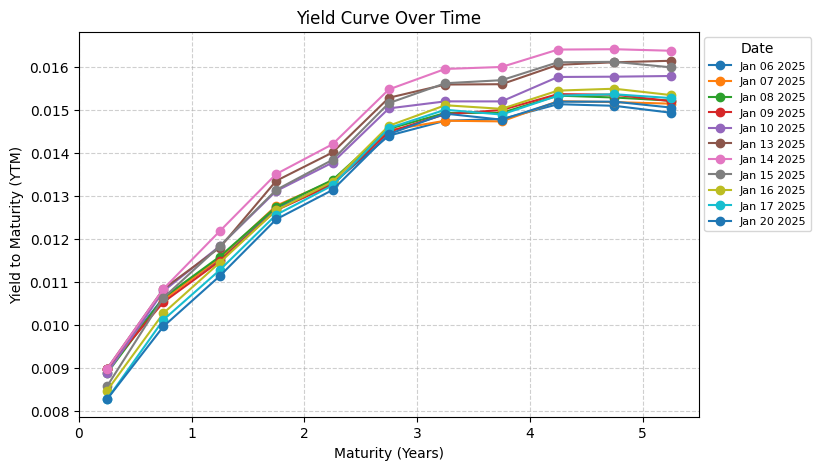

In [77]:
import matplotlib.pyplot as plt

# Example list of lists (each subarray is a different set of points)

maturities = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]
dates = ["Jan 06 2025", "Jan 07 2025", "Jan 08 2025", "Jan 09 2025", "Jan 10 2025",
         "Jan 13 2025", "Jan 14 2025", "Jan 15 2025", "Jan 16 2025", "Jan 17 2025", "Jan 20 2025"]

# Convert ytm_array to have each row as a date's yield curve (transpose)
ytm_array2 = list(map(list, zip(*ytm_array)))  # Now each sublist corresponds to a date



# Create line plot
plt.figure(figsize=(8, 5))

# Plot each date's yield curve
for i, ytm_values in enumerate(ytm_array2):
    plt.plot(maturities, ytm_values, marker='o', linestyle='-', label=dates[i])

# Labels and title
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (YTM)")
plt.title("Yield Curve Over Time")
plt.legend(title="Date", fontsize=8, loc="upper left", bbox_to_anchor=(1,1))  # Legend outside
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

##Plotting the Interpolated YTM curve


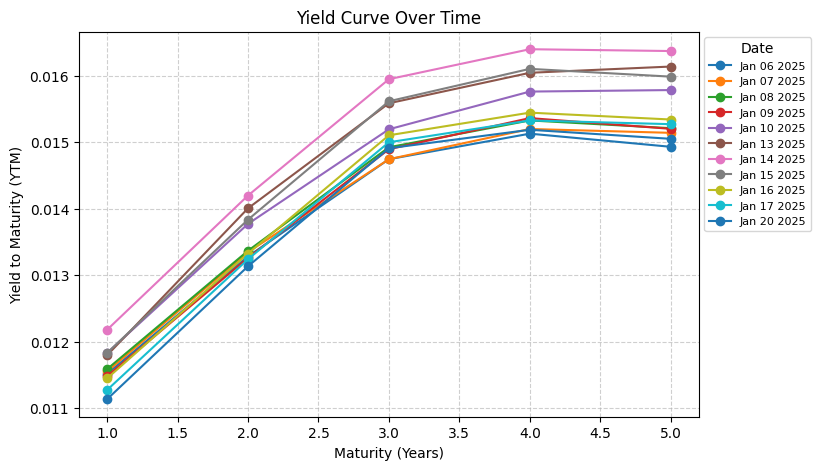

In [78]:
maturities = [1,2,3,4,5]




plt.figure(figsize=(8, 5))

# Plot each date's yield curve
for i, ytm_values in enumerate(interpolated_YTM_all):
    plt.plot(maturities, ytm_values, marker='o', linestyle='-', label=dates[i])

# Labels and title
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (YTM)")
plt.title("Yield Curve Over Time")
plt.legend(title="Date", fontsize=8, loc="upper left", bbox_to_anchor=(1,1))  # Legend outside
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()



## Plotting the Spot rate curve

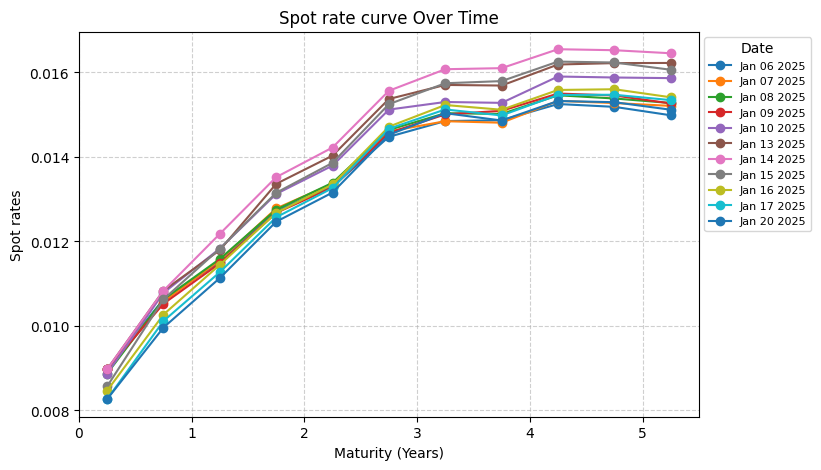

In [79]:
import matplotlib.pyplot as plt

# Example list of lists (each subarray is a different set of points)

maturities = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]
dates = ["Jan 06 2025", "Jan 07 2025", "Jan 08 2025", "Jan 09 2025", "Jan 10 2025",
         "Jan 13 2025", "Jan 14 2025", "Jan 15 2025", "Jan 16 2025", "Jan 17 2025", "Jan 20 2025"]

# Convert ytm_array to have each row as a date's yield curve (transpose)

# Create line plot
plt.figure(figsize=(8, 5))

# Plot each date's yield curve
for i, spot_rate_values in enumerate(spot_rates_all):
    plt.plot(maturities, spot_rate_values, marker='o', linestyle='-', label=dates[i])

# Labels and title
plt.xlabel("Maturity (Years)")
plt.ylabel("Spot rates")
plt.title("Spot rate curve Over Time")
plt.legend(title="Date", fontsize=8, loc="upper left", bbox_to_anchor=(1,1))  # Legend outside
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


##Plotting the Interpolated Spot rate curve


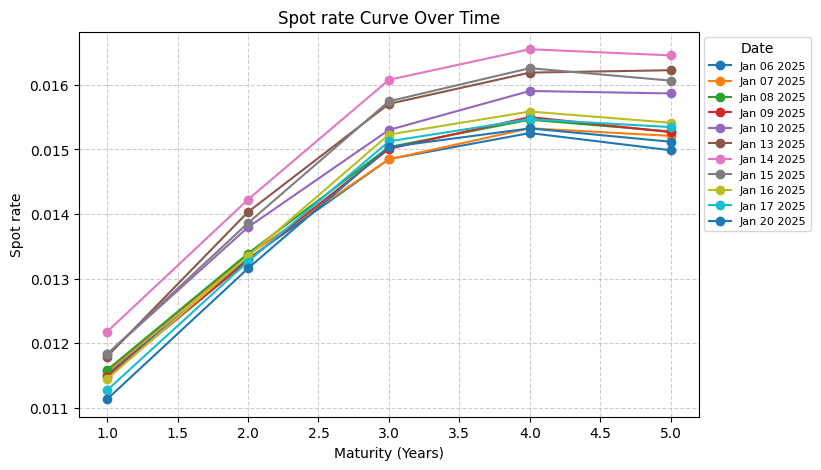

In [80]:
maturities = [1,2,3,4,5]



plt.figure(figsize=(8, 5))

# Plot each date's yield curve
for i, ytm_values in enumerate(interpolated_rates_all):
    plt.plot(maturities, ytm_values, marker='o', linestyle='-', label=dates[i])

# Labels and title
plt.xlabel("Maturity (Years)")
plt.ylabel("Spot rate")
plt.title("Spot rate Curve Over Time")
plt.legend(title="Date", fontsize=8, loc="upper left", bbox_to_anchor=(1,1))  # Legend outside
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

## Plotting the Forward rate curve

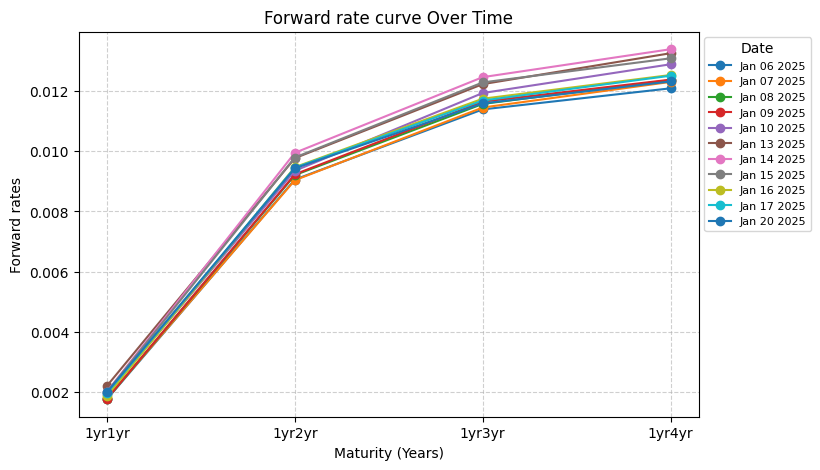

In [93]:
maturities = ['1yr1yr', '1yr2yr', '1yr3yr', '1yr4yr']
dates = ["Jan 06 2025", "Jan 07 2025", "Jan 08 2025", "Jan 09 2025", "Jan 10 2025",
         "Jan 13 2025", "Jan 14 2025", "Jan 15 2025", "Jan 16 2025", "Jan 17 2025", "Jan 20 2025"]

# Convert ytm_array to have each row as a date's yield curve (transpose)

# Create line plot
plt.figure(figsize=(8, 5))

# Plot each date's yield curve
for i, forward_rate_values in enumerate(forward_rates_all):
    plt.plot(maturities, forward_rate_values, marker='o', linestyle='-', label=dates[i])

# Labels and title
plt.xlabel("Maturity (Years)")
plt.ylabel("Forward rates")
plt.title("Forward rate curve Over Time")
plt.legend(title="Date", fontsize=8, loc="upper left", bbox_to_anchor=(1,1))  # Legend outside
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

##Now we calculate the covariance matrices for the random variables


In [82]:
import numpy as np

def create_random_variable(interpolated_rates_big):

  X_1 = []
  X_2 = []
  X_3 = []
  X_4 = []
  X_5 = []

  for j in range(1, len(interpolated_rates_big)-1): #j goes from 1 to 9
    for i in range(len(interpolated_rates_big[j])): #i goes from 0 to 4
      # Use a conditional to append to the correct list
      if i == 0:
        X_1.append(np.log(interpolated_rates_big[j+1][i]/interpolated_rates_big[j][i]))
      elif i == 1:
        X_2.append(np.log(interpolated_rates_big[j+1][i]/interpolated_rates_big[j][i]))
      elif i == 2:
        X_3.append(np.log(interpolated_rates_big[j+1][i]/interpolated_rates_big[j][i]))
      elif i == 3:
        X_4.append(np.log(interpolated_rates_big[j+1][i]/interpolated_rates_big[j][i]))
      elif i == 4:
        X_5.append(np.log(interpolated_rates_big[j+1][i]/interpolated_rates_big[j][i]))


  return X_1,X_2,X_3,X_4,X_5

In [83]:
print(create_random_variable(interpolated_YTM_all))

([0.003009719719467599, -0.0090552198160133, 0.029884723149088153, -0.002950431516426504, 0.03200732634505307, -0.029056894828626677, -0.032920606661109755, -0.015312856718379531, -0.012413655437359254], [0.0015911530561503523, -0.007979197112341832, 0.037776587495510404, 0.016885300994530037, 0.01362327180036232, -0.025877465237610607, -0.03761314003547052, -0.00639746015769123, -0.008050256768284388], [0.012126607932681404, -0.0020120859575606396, 0.019961642142885292, 0.02543551114658894, 0.022984417524562675, -0.02105122681880536, -0.033320324455864594, -0.006983325490069804, -0.006020203460218469], [0.008438158537312833, 0.0022908110901367408, 0.025654960280314876, 0.017778646004618447, 0.021853758879442464, -0.018183329275953942, -0.04177614330856665, -0.007618703669991913, -0.009208286910887264], [0.004622531705794606, -0.0006592838507439194, 0.037659717341901267, 0.022176378487986235, 0.014358000802232084, -0.02381308396564883, -0.041183467196980336, -0.0045900633175935965, -0.

In [84]:
#Should the matrix arrangement be 5x9 or 9x5
X_1,X_2,X_3,X_4,X_5 = create_random_variable(interpolated_YTM_all)

data_matrix = np.vstack([X_1, X_2, X_3, X_4, X_5])

# Calculate the covariance matrix
covariance_matrix = np.cov(data_matrix)

# The result will be a 5x5 matrix
print(covariance_matrix)

[[0.00052293 0.00046433 0.00040596 0.00044373 0.00047669]
 [0.00046433 0.00051569 0.00043038 0.0004657  0.0005383 ]
 [0.00040596 0.00043038 0.00041869 0.00043109 0.00046296]
 [0.00044373 0.0004657  0.00043109 0.00046837 0.00050419]
 [0.00047669 0.0005383  0.00046296 0.00050419 0.00057871]]


In [85]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:\n", eigenvectors)

Eigenvalues: [2.35814075e-03 8.70015041e-05 4.46037315e-05 2.95269712e-06
 1.16821874e-05]
Eigenvectors:
 [[-0.43907616 -0.88533558 -0.03276022 -0.14858089  0.01560496]
 [-0.45920391  0.15088157 -0.55117213  0.53544486 -0.41937408]
 [-0.4076946   0.19708611  0.65974692 -0.17527149 -0.57354693]
 [-0.43920857  0.13481974  0.37705516  0.47927066  0.64579293]
 [-0.48705733  0.36931878 -0.34307355 -0.65635514  0.27906499]]


In [86]:
def create_random_variable_forward(forward_rates_big):

  Y_2 = []
  Y_3 = []
  Y_4 = []
  Y_5 = []

  for j in range(1, len(forward_rates_big)-1): #j goes from 1 to 9
    for i in range(len(forward_rates_big[j])): #i goes from 0 to 3
      # Use a conditional to append to the correct list
      if i == 0:
        Y_2.append(np.log(forward_rates_big[j+1][i]/forward_rates_big[j][i]))
      elif i == 1:
        Y_3.append(np.log(forward_rates_big[j+1][i]/forward_rates_big[j][i]))
      elif i == 2:
        Y_4.append(np.log(forward_rates_big[j+1][i]/forward_rates_big[j][i]))
      elif i == 3:
        Y_5.append(np.log(forward_rates_big[j+1][i]/forward_rates_big[j][i]))



  return Y_2,Y_3,Y_4,Y_5

In [87]:
print(create_random_variable_forward(forward_rates_all))

([0.0005360210222489309, -0.007186757131818877, 0.04395812399046245, 0.031745435310400236, -1.7536608954965368e-05, -0.02346352186930532, -0.04122648985881971, 0.000385907672223542, -0.004786655995232049], [0.016010833808990408, 0.0006864437885972913, 0.015707324817835364, 0.03594110121798822, 0.02051492454236244, -0.018120000497288572, -0.03337932135973874, -0.0041315368125997565, -0.0036987331008591956], [0.00988421474181539, 0.0053586940126651, 0.024729051963172353, 0.022395949496946007, 0.01987654556929808, -0.01533992564441884, -0.04426832858140165, -0.005851601139109454, -0.00857506663170183], [0.004728270776924953, 0.0008227910338717612, 0.04000425602147371, 0.02679620492401135, 0.01093105700174995, -0.02314238991585307, -0.042891669851081914, -0.0024504846154494264, -0.015348979328535623])


In [88]:
Y_2,Y_3,Y_4,Y_5 = create_random_variable_forward(forward_rates_all)

data_matrixY = np.vstack([Y_2, Y_3, Y_4, Y_5])

# Calculate the covariance matriY
covariance_matrixY = np.cov(data_matrixY)

# The result will be a 5Y5 matriY
print(covariance_matrixY)

[[0.00065816 0.00045654 0.00049853 0.00062367]
 [0.00045654 0.00044907 0.00044345 0.00047646]
 [0.00049853 0.00044345 0.00049123 0.00053225]
 [0.00062367 0.00047646 0.00053225 0.00063472]]


In [89]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrixY)

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:\n", eigenvectors)

Eigenvalues: [2.09109206e-03 1.05537680e-04 3.06394886e-05 5.90330199e-06]
Eigenvectors:
 [[ 0.53985319  0.64115531  0.38066641  0.390604  ]
 [ 0.43544753 -0.61871587  0.62425901 -0.19461965]
 [ 0.47042521 -0.40377314 -0.55559582  0.55405836]
 [ 0.54556769  0.20755192 -0.39586242 -0.70892245]]
